In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
import pickle, time, logging, glob, pathlib, random
from sklearn.metrics import r2_score
from sklearnex import patch_sklearn
import torch, math
from torch.utils.data import  Dataset, DataLoader
from functools import lru_cache 
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

root = pathlib.Path(f"/kaggle/input/jane-street-data-loader/train.npy")
def get_paths(nums: list) -> list:
    return [root/f"symbol={i}/window=4/part-0.npz" for i in nums] 

train_paths = get_paths(range(36))
val_paths = get_paths(range(36,38))
final_path = get_paths([38])

In [2]:
cfg = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "window": 4, 
    "batch_size":96, 
    "shuffle":False,
    "dim": np.load(train_paths[0], allow_pickle=True)["data"].shape[-1],
    "drop_last":True, 
    "num_workers":1,
    "frac": None,
    "pin_memory": True, 
    "prefetch_factor":2,
    "persistent_workers":True
}

In [3]:
cfg

{'device': device(type='cpu'),
 'window': 4,
 'batch_size': 96,
 'shuffle': False,
 'dim': 31,
 'drop_last': True,
 'num_workers': 1,
 'frac': None,
 'pin_memory': True,
 'prefetch_factor': 2,
 'persistent_workers': True}

# Generate pytorch dataset

In [4]:
class JaneStreetDatasetV1(Dataset):
    def __init__(self, paths, cfg):
        self.file_mappings = []
        self.total_rows = 0
        self.frac = cfg["frac"]

        
        for path in tqdm(paths, desc="Processing financial instruments"):
            data = np.load(path,allow_pickle=True)["target"]
            size = int(data.shape[0] * self.frac) if self.frac else data.shape[0]
            self.file_mappings.append((path, self.total_rows, self.total_rows + size)) # Map cumulative row count to file path
            self.total_rows += size
            

    @lru_cache(maxsize = 10)
    def load_file(self, path_name):
        train_npy = np.load(path_name, allow_pickle=True, mmap_mode="r")
        return train_npy["data"], train_npy["target"]
    
    def __len__(self):
        return self.total_rows
    
    def __getitem__(self, idx):
        for path, offset, sum_k in self.file_mappings:
            if idx < sum_k:
                size = idx - offset
                data, targets = self.load_file(path)
                return (
                    torch.tensor(data[size], dtype=torch.float32),
                    torch.tensor(targets[size], dtype=torch.float32).unsqueeze(0)
                )

In [5]:
def create_dataloader_v1(paths, cfg):
    dataset = JaneStreetDatasetV1(paths, cfg)
    dataloader = DataLoader(dataset=dataset,
                            batch_size=cfg["batch_size"],
                            shuffle=cfg["shuffle"],
                            drop_last=cfg["drop_last"],
                            num_workers=cfg["num_workers"]
                           )
    
    return dataloader

In [6]:
def get_slopes(n):
    def get_slopes_power_of_2(n):
        start = (2**(-2**-(math.log2(n)-3)))
        ratio = start
        return [start*ratio**i for i in range(n)]

    if math.log2(n).is_integer():
        return get_slopes_power_of_2(n)                   #In the paper, we only train models that have 2^a heads for some a. This function has
    else:                                                 #some good properties that only occur when the input is a power of 2. To maintain that even
        closest_power_of_2 = 2**math.floor(math.log2(n))  #when the number of heads is not a power of 2, we use this workaround.
        return get_slopes_power_of_2(closest_power_of_2) + get_slopes(2*closest_power_of_2)[0::2][:n-closest_power_of_2]

def get_alibi_slope(num_heads):
    return torch.Tensor(get_slopes(num_heads)).unsqueeze(1).unsqueeze(1)

def get_alibi_bias(num_heads, seq_len):
    relative_pos = torch.arange(seq_len)[None, :] - torch.arange(seq_len)[:, None]
    m = get_alibi_slope(num_heads)
    return m * relative_pos
    
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
      torch.nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out', nonlinearity='leaky_relu') #torch.nn.init.normal_(m.weight, mean=0.0, std=1/math.sqrt(6))
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, torch.nn.Embedding):
        torch.nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out', nonlinearity='leaky_relu') #torch.nn.init.normal_(m.weight, mean=0.0, std=1/math.sqrt(6))


class MultiHeadMaskAttention(torch.nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, window, bias, num_layers):
        super().__init__()
        self.num_heads = num_heads
        self.pos_emb = torch.nn.Embedding(window, dim_in)
        self.W_query = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.W_key = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.W_value = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.out_proj = torch.nn.Linear(dim_out, dim_out)
        self.attn_scale = math.sqrt(dim_in)
        self.softmax = torch.nn.Softmax(dim=-1)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(window,window), diagonal=1).bool()
        )
        
        self.register_buffer(
            "bias",
            get_alibi_bias(num_heads, window)
        )

    def forward(self, inp):
        batch, window, emb = inp.shape
        pos_emb = self.pos_emb(torch.arange(window, device=inp.device))

        queries = self.W_query(inp)
        keys = self.W_key(inp)
        values = self.W_value(inp)

        keys = keys.view(batch, window, self.num_heads, emb)
        queries = queries.view(batch, window, self.num_heads, emb)
        values = values.view(batch, window, self.num_heads, emb)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2) + pos_emb

        attn_scores = (queries @ keys.mT)/self.attn_scale + self.bias
        attn_scores = attn_scores.masked_fill(self.mask, -torch.inf)
        attn_weights = self.softmax(attn_scores)
        context_vectors = (attn_weights @ values).transpose(1,2).mean(dim=-2)
        return self.out_proj(context_vectors)/0.01

class LayerNorm(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.eps = 1e-5
        self.shift = torch.nn.Parameter(torch.zeros(dim))
        self.scale = torch.nn.Parameter(torch.ones(dim))

    def forward(self, inp):
        mean = inp.mean(dim=-1, keepdim=True)
        var = inp.var(dim=-1, keepdim=True, unbiased=False)
        inp_norm = (inp - mean)/(torch.sqrt(var)+self.eps)

        return inp_norm + self.shift * self.scale

class FeedForwardLayer(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(cfg["n_features"], cfg["n_features"] * cfg["window"]),
            torch.nn.LeakyReLU(), #torch.nn.GELU(approximate="tanh"),
            torch.nn.Linear(cfg["n_features"] * cfg["window"], cfg["n_features"]),
        )


    def forward(self, inp):
        return self.layer(inp)

class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attention = MultiHeadMaskAttention(dim_in=cfg["n_features"], dim_out=cfg["n_features"], num_heads=cfg["num_heads"],
                                                window=cfg["window"], bias=cfg["qkv_bias"], num_layers=cfg["n_layers"])
        self.forward_layer = FeedForwardLayer(cfg)
        self.norm1 = LayerNorm(cfg["n_features"])
        self.norm2 = LayerNorm(cfg["n_features"])
        self.dropout = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, inp):
        shortcut = inp
        inp = self.norm1(inp)
        inp = self.attention(inp)
        inp = inp + shortcut

        shortcut = inp
        inp = self.norm2(inp)
        inp = self.forward_layer(inp)
        out = self.dropout(inp)
        return out + shortcut

In [7]:
class JaneStreetModelV1(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.norm =  LayerNorm(cfg["n_features"])
        self.final_norm = LayerNorm(cfg["n_features"])
        self.out_proj = torch.nn.Linear(cfg["n_features"], 1, bias=False)

    def forward(self, inp):
        inp = self.blocks(self.norm(inp))
        inp = inp.mean(dim=1)/0.1
        inp = self.final_norm(inp)

        return self.out_proj(inp)

In [8]:
MODEL_CONFIG = {
    "n_features": cfg["dim"],
    "window": cfg["window"],
    "num_heads": 3,
    "n_layers": 3,
    "drop_rate": 0.05,
    "qkv_bias": False
}

In [9]:
def calc_loss_batch(inp, targets, device):
    inp = inp.to(device)
    targets = targets.to(device)
    outputs = model(inp)
    loss = torch.nn.functional.l1_loss(outputs, targets)

    return loss.item(), outputs

def evaluate_model(val_loader, num_batch, device, choices):
    total_loss = 0
    for i, (inp, targets) in enumerate(val_loader):
        if i < num_batch:
            with torch.no_grad():
                loss, outputs = calc_loss_batch(
                    inp=inp, targets=targets, device=device
                )
            total_loss += loss
        else:
            break
    outputs = outputs.flatten().detach().cpu().numpy()
    targets = targets.flatten().detach().cpu().numpy()
    print(f"Sample predictions range: (max:{max(outputs)}, min:{min(outputs)}) - Targets range: (max:{max(targets)}, min:{min(targets)})")
    return total_loss/num_batch

def train_epoch(train_loader, device, freq, choices, global_step,
                half_loops, start_lr, min_lr):
    last_loss, running_loss = 0., 0.
    time_step = 0.
    scores = []
    total_len = len(train_loader)

    for batch, (input_batch, targets_batch) in enumerate(train_loader):
        #compute time per step
        start_time = time.time()
        #transfer data to device
        input_batch = input_batch.to(device)
        targets_batch = targets_batch.to(device)
        #zero gradients for every batch
        optimizer.zero_grad()
        global_step += 1
        if global_step <= half_loops:
            # Apply cosine decay to halfway point
            optimizer.param_groups[0]["lr"] = min_lr + 0.5 * (start_lr - min_lr) * (1 + math.cos(math.pi * global_step / half_loops))
        else:
            # Maintain the minimum learning rate beyond halfway point
            optimizer.param_groups[0]["lr"] = min_lr
        outputs = model(input_batch)
        loss = torch.nn.functional.huber_loss(outputs, targets_batch)
        loss.backward()
        optimizer.step()
        time_step += time.time() - start_time

        running_loss += loss.item()
        if batch % freq == freq-1:
            last_loss = running_loss / freq
            print(f"Batch {batch}/{total_len} - {time_step/freq:.3f}s/step - loss: {last_loss} - lr: {optimizer.param_groups[0]['lr']}")
            # print(f"Model prediction: {outputs[choices].flatten().detach().cpu().numpy()} - Target: {targets_batch[choices].flatten().cpu().numpy()} ")
            running_loss = 0.
            time_step = 0.
            scores.append(last_loss)

    return np.mean(scores), global_step

def train_model(epochs, train_loader, freq, device, frac=4, min_lr=5e-4, num_batch=None, val_loader=None):

    global_step = -1
    total_loops = len(train_loader) * epochs
    half_loops = total_loops // frac
    start_lr = optimizer.param_groups[0]["lr"]
    history = {"loss": []}

    choices = random.choices(range(cfg["batch_size"]-10),k=3)
    for i in range(epochs):
        print(f"Epoch {i+1}/{epochs}")
        #set model to training mode
        model.train(True)
        #train model
        avg_loss, global_step = train_epoch(
            train_loader=train_loader, device=device, freq=freq, choices=choices,
            global_step=global_step, half_loops=half_loops, start_lr=start_lr, min_lr=min_lr
        )

        if val_loader:
            model.eval()
            avg_vloss = evaluate_model(
                val_loader=val_loader, num_batch=num_batch, choices=choices, device=device
            )
            history["val_loss"] = history.get('val_loss', []) + [avg_vloss]
            print(f"train loss: {avg_loss} - val loss: {avg_vloss}")
        else:
            print(f"train loss: {avg_loss}")
        history["loss"].append(avg_loss)

    return history

In [10]:
cfg["frac"] = 0.08
folds = 5
kfold = KFold(n_splits=folds, random_state=123, shuffle=True)
paths = np.array(train_paths[:7])
historys = {"val_loss": [], "loss": [], "val_score":[], "score":[]}
for train_path, test_path in kfold.split(paths):
    train = create_dataloader_v1(paths[train_path], cfg)
    test = create_dataloader_v1(paths[test_path], cfg)

    torch.manual_seed(11) #11 #32
    model = JaneStreetModelV1(MODEL_CONFIG)
    # model.apply(init_weights)
    model.to(cfg["device"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=5e-3, weight_decay=1e-4
    )
    num_epochs = 5
    history = train_model(epochs=num_epochs, train_loader=train, val_loader=test, frac=1, 
                          freq=len(train)//2, min_lr=3e-4, num_batch=len(test), device=cfg["device"])

    print(f'Epochs({num_epochs}): Train error: {np.mean(history["loss"]):.7f} - Validation Error: {np.mean(history["val_loss"]):.7f}')
    print()
    historys["val_score"].append(history["val_loss"][-1])
    historys["score"].append(history["loss"][-1])
    historys["val_loss"].append(history["val_loss"])
    historys["loss"].append(history["loss"])

print(f"""KFold Cross Validation: {folds} - Mean Train error: {np.mean(historys["score"]):.7f} - Mean Validation error: {np.mean(historys["val_score"]):.7f}""")

Processing financial instruments: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Epoch 1/5
Batch 2209/4421 - 0.030s/step - loss: 0.2530304591304188 - lr: 0.00488513757315797
Batch 4419/4421 - 0.030s/step - loss: 0.32345043791361083 - lr: 0.004551582483117778
Sample predictions range: (max:-0.010493695735931396, min:-0.04049939662218094) - Targets range: (max:0.41406866908073425, min:-1.461663842201233)
train loss: 0.2882404485220148 - val loss: 0.5229794160578023
Epoch 2/5
Batch 2209/4421 - 0.030s/step - loss: 0.24884982371757575 - lr: 0.004031700611044629
Batch 4419/4421 - 0.030s/step - loss: 0.3233204077853404 - lr: 0.0033768251850288464
Sample predictions range: (max:-0.01992638036608696, min:-0.034585725516080856) - Targets range: (max:0.41406866908073425, min:-1.461663842201233)
train loss: 0.28608511575145806 - val loss: 0.5232074733129904
Epoch 3/5
Batch 2209/4421 - 0.030s/step - loss: 0.24873536005869035 - lr: 0.002650500977788737
Batch 4419/4421 - 0.031s/step - loss: 0.3233740571001334 - lr: 0.001924445370138327
Sample predictions range: (max:0.01013112161

Processing financial instruments: 100%|██████████| 2/2 [00:00<00:00, 26.44it/s]

Epoch 1/5


Batch 2558/5119 - 0.031s/step - loss: 0.28683306123406616 - lr: 0.00488511647689525
Batch 5117/5119 - 0.031s/step - loss: 0.27804864916751026 - lr: 0.004551528966603078
Sample predictions range: (max:-0.026191508397459984, min:-0.027963683009147644) - Targets range: (max:1.488620638847351, min:-1.3970130681991577)
train loss: 0.2824408552007882 - val loss: 0.5264253930811502
Epoch 2/5
Batch 2558/5119 - 0.032s/step - loss: 0.2834457935448394 - lr: 0.004031645354500546
Batch 5117/5119 - 0.031s/step - loss: 0.2780784552666858 - lr: 0.0033767385693650605
Sample predictions range: (max:-0.02140282839536667, min:-0.030162638053297997) - Targets range: (max:1.488620638847351, min:-1.3970130681991577)
train loss: 0.2807621244057626 - val loss: 0.5265597232346819
Epoch 3/5
Batch 2558/5119 - 0.032s/step - loss: 0.2833600987583084 - lr: 0.0026504326670850303
Batch 5117/5119 - 0.032s/step - loss: 0.2776714206661195 - lr: 0.0019243587395650623
Sample predictions range: (max:-0.011744152754545212, m

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]

Epoch 1/5


Batch 2837/5676 - 0.030s/step - loss: 0.23121223266848834 - lr: 0.004885063186949006
Batch 5675/5676 - 0.033s/step - loss: 0.27973909880673475 - lr: 0.004551342830956885
Sample predictions range: (max:-0.013912004418671131, min:-0.05625529959797859) - Targets range: (max:1.1233549118041992, min:-0.8411837220191956)
train loss: 0.25547566573761155 - val loss: 0.668901253799067
Epoch 2/5
Batch 2837/5676 - 0.037s/step - loss: 0.22784729274347493 - lr: 0.004031505791236233
Batch 5675/5676 - 0.033s/step - loss: 0.27936393610496135 - lr: 0.0033764373391525376
Sample predictions range: (max:0.029133643954992294, min:-0.0673184022307396) - Targets range: (max:1.1233549118041992, min:-0.8411837220191956)
train loss: 0.25360561442421814 - val loss: 0.6681248648001731
Epoch 3/5
Batch 2837/5676 - 0.033s/step - loss: 0.22705883290726953 - lr: 0.002650260138926035
Batch 5675/5676 - 0.032s/step - loss: 0.2786259723504742 - lr: 0.0019240574744889567
Sample predictions range: (max:0.037586092948913574,

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s]

Epoch 1/5


Batch 3015/6032 - 0.029s/step - loss: 0.2326778330743209 - lr: 0.004885058444171489
Batch 6031/6032 - 0.032s/step - loss: 0.3297645635534066 - lr: 0.004551333808008568
Sample predictions range: (max:-0.027911968529224396, min:-0.035453155636787415) - Targets range: (max:0.8920153379440308, min:-1.2351021766662598)
train loss: 0.2812211983138638 - val loss: 0.48816968872720345
Epoch 2/5
Batch 3015/6032 - 0.032s/step - loss: 0.23146438588844043 - lr: 0.004031493371346167
Batch 6031/6032 - 0.032s/step - loss: 0.329874705825446 - lr: 0.0033764227380660965
Sample predictions range: (max:-0.035262707620859146, min:-0.03892267122864723) - Targets range: (max:0.8920153379440308, min:-1.2351021766662598)
train loss: 0.2806695458569432 - val loss: 0.4884590191109091
Epoch 3/5
Batch 3015/6032 - 0.030s/step - loss: 0.22975651668823158 - lr: 0.0026502447858992896
Batch 6031/6032 - 0.030s/step - loss: 0.3301287597313837 - lr: 0.001924042872383137
Sample predictions range: (max:-0.04598522558808327, 

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 45.87it/s]


Epoch 1/5
Batch 3200/6403 - 0.032s/step - loss: 0.23198985423260216 - lr: 0.004885089679272566
Batch 6401/6403 - 0.031s/step - loss: 0.3035546972601311 - lr: 0.004551460989798385
Sample predictions range: (max:0.0018044598400592804, min:0.0002731138374656439) - Targets range: (max:3.482450485229492, min:-1.2162364721298218)
train loss: 0.26777227574636664 - val loss: 0.6678344891031505
Epoch 2/5
Batch 3200/6403 - 0.032s/step - loss: 0.2292647906689637 - lr: 0.0040315751700752064
Batch 6401/6403 - 0.034s/step - loss: 0.30357348687473423 - lr: 0.003376628555033307
Sample predictions range: (max:0.0012327621225267649, min:-0.0027683235239237547) - Targets range: (max:3.482450485229492, min:-1.2162364721298218)
train loss: 0.266419138771849 - val loss: 0.667720426188705
Epoch 3/5
Batch 3200/6403 - 0.033s/step - loss: 0.22895414486233004 - lr: 0.002650345903922034
Batch 6401/6403 - 0.031s/step - loss: 0.3032567437404827 - lr: 0.0019242487094417293
Sample predictions range: (max:0.0141690541

KFold Cross Validation: 5 - Mean Train error: 0.2723487 - Mean Validation error: 0.5745481


In [11]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0.0001
)

In [12]:
for name, param in model.named_parameters():
    if "weight" in name:
        print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

blocks.0.attention.pos_emb.weight has gradient mean of 0.00024935431429184973
blocks.0.attention.W_query.weight has gradient mean of 1.2242545608387445e-06
blocks.0.attention.W_key.weight has gradient mean of 4.1290686567663215e-06
blocks.0.attention.W_value.weight has gradient mean of 6.38242345303297e-05
blocks.0.attention.out_proj.weight has gradient mean of 4.595916107064113e-05
blocks.0.forward_layer.layer.0.weight has gradient mean of 1.2258426522748778e-06
blocks.0.forward_layer.layer.2.weight has gradient mean of 1.338187871624541e-06
blocks.1.attention.pos_emb.weight has gradient mean of 8.424515726801474e-06
blocks.1.attention.W_query.weight has gradient mean of 5.6750145915884787e-08
blocks.1.attention.W_key.weight has gradient mean of 6.11872863487406e-08
blocks.1.attention.W_value.weight has gradient mean of 5.546973625314422e-06
blocks.1.attention.out_proj.weight has gradient mean of 0.00018140145402867347
blocks.1.forward_layer.layer.0.weight has gradient mean of 7.88613

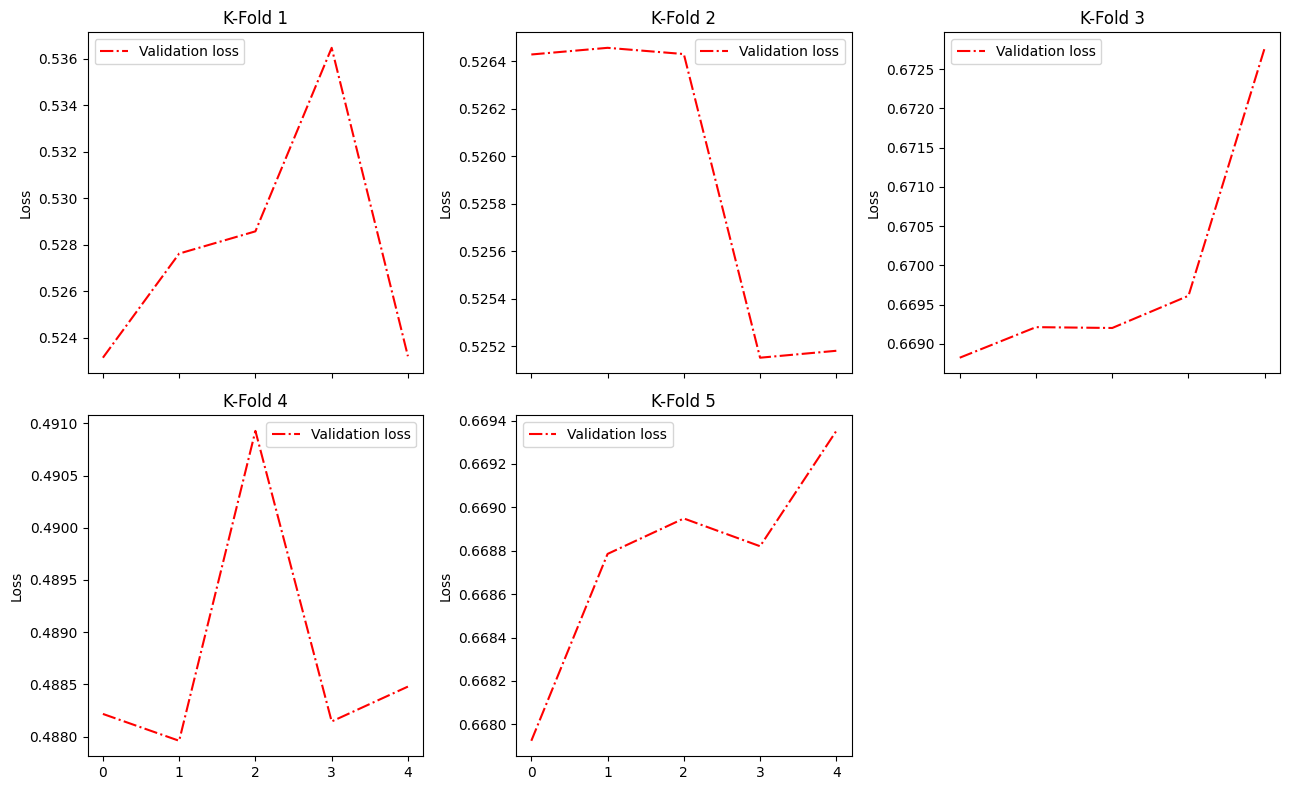

In [13]:
def plot_losses(epochs, train_loss, val_loss):
    plots = len(train_loss)  # Number of distinct plots
    rows, cols = 2, 3  # Define grid dimensions (2 rows, 3 columns)
    
    fig, axes = plt.subplots(figsize=(13, 8), nrows=rows, ncols=cols, sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for i in range(plots):
        # axes[i].plot(range(epochs), train_loss[i], label="Training loss", c="b")
        axes[i].plot(range(epochs), val_loss[i], linestyle="-.", label="Validation loss", c="r")
        axes[i].set_ylabel("Loss")
        axes[i].set_title(f"K-Fold {i+1}")
        axes[i].legend(loc="best")    
    for i in range(plots, len(axes)):
        axes[i].axis('off')
    
    fig.tight_layout()
    plt.show()

plot_losses(epochs=num_epochs, train_loss=historys["loss"], val_loss=historys["val_loss"])

In [14]:
evaluate_model(test, len(test), cfg["device"], choices=np.random.choice(64, 3).tolist())

Sample predictions range: (max:0.056338440626859665, min:-0.10380475223064423) - Targets range: (max:3.482450485229492, min:-1.2162364721298218)


0.667172862527881

In [15]:
for i, (inp, target) in enumerate(train):
    with torch.no_grad():
        inp = inp.to(cfg["device"])
        preds = model(inp)
    print(f"Predictions: (max:{preds.max().item():.5f}, min:{preds.min().item():.5f}), Targets: (max:{target.max().item():.5f}, min:{target.min().item():.5f})")
    if i == 50:
        break

Predictions: (max:0.08669, min:-0.11756), Targets: (max:1.77882, min:-2.61569)
Predictions: (max:0.07794, min:-0.08665), Targets: (max:1.61126, min:-2.23431)
Predictions: (max:0.06778, min:-0.08440), Targets: (max:2.32675, min:-1.71504)
Predictions: (max:0.07553, min:-0.08385), Targets: (max:1.01496, min:-3.19004)
Predictions: (max:0.05968, min:-0.07987), Targets: (max:1.27533, min:-0.87100)
Predictions: (max:0.04892, min:-0.09283), Targets: (max:1.50749, min:-1.42137)
Predictions: (max:0.04677, min:-0.10088), Targets: (max:0.89639, min:-1.36691)
Predictions: (max:0.05636, min:-0.09441), Targets: (max:1.78184, min:-1.06820)
Predictions: (max:0.05272, min:-0.08518), Targets: (max:1.74002, min:-1.37756)
Predictions: (max:0.05286, min:-0.08736), Targets: (max:1.65491, min:-2.75220)
Predictions: (max:0.16998, min:-0.08355), Targets: (max:1.80574, min:-5.00000)
Predictions: (max:0.06603, min:-0.10326), Targets: (max:1.45443, min:-1.21739)
Predictions: (max:0.05978, min:-0.08073), Targets: (

### Train Model For Submission

In [16]:
cfg["frac"] = None
train_paths = get_paths(range(39))
train_loader = create_dataloader_v1(train_paths, cfg)

In [17]:
torch.manual_seed(11) #11 #32
model = JaneStreetModelV1(MODEL_CONFIG)
model.to(cfg["device"])
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0003, weight_decay=0.8
)
num_epochs = 5
history = train_model(epochs=num_epochs, train_loader=train_loader, freq=len(train_loader)//10, 
                      device=cfg["device"])

print(f"""Epochs: {num_epochs}\nTrain error: {np.mean(history["loss"]):.7f}""")

In [18]:
torch.save({
 "model_state_dict": model.state_dict(),
 "optimizer_state_dict": optimizer.state_dict(),
 },
 "/kaggle/working/model_and_optimizer.pth"
)

### Multiple models

In [20]:
torch.manual_seed(11)
cfg["frac"] = None
# models = {}
models = torch.load("/kaggle/input/model-checkpoint/models.pth", weights_only=True,map_location=cfg["device"])

for symbol in tqdm(range(len(models.keys()),39), desc="Model training"):
    data_loader = create_dataloader_v1(get_paths([symbol]), cfg)
    model = JaneStreetModelV1(MODEL_CONFIG)
    model.to(cfg["device"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=5e-3, weight_decay=1e-4
    )
    num_epochs = 5
    history = train_model(epochs=num_epochs, train_loader=data_loader, frac=1, min_lr=3e-4,
                          freq=len(data_loader)//2, device=cfg["device"])
    models[symbol] = model.state_dict()
    print(f"""Epochs: {num_epochs} - Train error: {history["loss"][-1]:.7f}""")
    print()
    torch.save(models, "/kaggle/working/models.pth")

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]

Epoch 1/5


Batch 7442/14886 - 0.029s/step - loss: 0.30306845710093683 - lr: 0.004885013462827235
Batch 14885/14886 - 0.029s/step - loss: 0.30465974948090807 - lr: 0.004551248237751825
train loss: 0.30386410329092245
Epoch 2/5
Batch 7442/14886 - 0.029s/step - loss: 0.30117412800507737 - lr: 0.004031375588389866
Batch 14885/14886 - 0.030s/step - loss: 0.30414169770067984 - lr: 0.003376284271826643
train loss: 0.3026579128528786
Epoch 3/5
Batch 7442/14886 - 0.030s/step - loss: 0.30067702074223374 - lr: 0.0026500991904169525
Batch 14885/14886 - 0.031s/step - loss: 0.30357547717620137 - lr: 0.0019239043995581506
train loss: 0.3021262489592176
Epoch 4/5
Batch 7442/14886 - 0.032s/step - loss: 0.29959974511107723 - lr: 0.001268784905076122
Batch 14885/14886 - 0.031s/step - loss: 0.3029390659097426 - lr: 0.000748868367576682
train loss: 0.3012694055104099
Epoch 5/5
Batch 7442/14886 - 0.032s/step - loss: 0.2989340448305279 - lr: 0.0004150478402217997


Model training:  11%|█         | 1/9 [43:14<5:45:54, 2594.30s/it]

Batch 14885/14886 - 0.031s/step - loss: 0.3026467532791742 - lr: 0.00030000000209334863
train loss: 0.30079039905485105
Epochs: 5 - Train error: 0.3007904




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

Epoch 1/5


Batch 3729/7461 - 0.030s/step - loss: 0.3917517513388783 - lr: 0.004885074528190694
Batch 7459/7461 - 0.030s/step - loss: 0.2615836339045176 - lr: 0.004551422557839561
train loss: 0.3266676926216979
Epoch 2/5
Batch 3729/7461 - 0.029s/step - loss: 0.3906111398263617 - lr: 0.004031535491268518
Batch 7459/7461 - 0.030s/step - loss: 0.2612418513489143 - lr: 0.003376566358892338
train loss: 0.325926495587638
Epoch 3/5
Batch 3729/7461 - 0.033s/step - loss: 0.3852783847580247 - lr: 0.0026502968533460517
Batch 7459/7461 - 0.037s/step - loss: 0.2594671399718345 - lr: 0.001924186505930495
train loss: 0.3223727623649296
Epoch 4/5
Batch 3729/7461 - 0.034s/step - loss: 0.38391770512182716 - lr: 0.0012689448275350682
Batch 7459/7461 - 0.031s/step - loss: 0.25868609270190784 - lr: 0.0007490427382098837
train loss: 0.3213018989118675
Epoch 5/5
Batch 3729/7461 - 0.032s/step - loss: 0.3831477363841064 - lr: 0.00041510893726684055


Model training:  22%|██▏       | 2/9 [1:05:51<3:37:47, 1866.83s/it]

Batch 7459/7461 - 0.032s/step - loss: 0.2581423045694079 - lr: 0.0003000000333321643
train loss: 0.32064502047675714
Epochs: 5 - Train error: 0.3206450




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

Epoch 1/5


Batch 3099/6201 - 0.032s/step - loss: 0.2899851131762919 - lr: 0.004885093159659209
Batch 6199/6201 - 0.031s/step - loss: 0.2744168718847551 - lr: 0.004551469818224732
train loss: 0.2822009925305235
Epoch 2/5
Batch 3099/6201 - 0.029s/step - loss: 0.2881651039420807 - lr: 0.004031584285051895
Batch 6199/6201 - 0.030s/step - loss: 0.2729965103251649 - lr: 0.0033766428427237896
train loss: 0.2805808071336228
Epoch 3/5
Batch 3099/6201 - 0.030s/step - loss: 0.2875810634429687 - lr: 0.0026503571718774805
Batch 6199/6201 - 0.029s/step - loss: 0.2722197294584475 - lr: 0.0019242629989842043
train loss: 0.2799003964507081
Epoch 4/5
Batch 3099/6201 - 0.030s/step - loss: 0.28659208566498673 - lr: 0.0012689936311856935
Batch 6199/6201 - 0.029s/step - loss: 0.27178786161738716 - lr: 0.0007490900227392355
train loss: 0.2791899736411869
Epoch 5/5
Batch 3099/6201 - 0.030s/step - loss: 0.2862639794621106 - lr: 0.0004151275847008995


Model training:  33%|███▎      | 3/9 [1:23:48<2:30:37, 1506.21s/it]

Batch 6199/6201 - 0.030s/step - loss: 0.27158474896200785 - lr: 0.00030000004825409
train loss: 0.27892436421205924
Epochs: 5 - Train error: 0.2789244




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

Epoch 1/5


Batch 7853/15709 - 0.030s/step - loss: 0.25335666953766817 - lr: 0.004885026377791813
Batch 15707/15709 - 0.029s/step - loss: 0.24668725433018626 - lr: 0.004551300427032632
train loss: 0.25002196193392723
Epoch 2/5
Batch 7853/15709 - 0.030s/step - loss: 0.24890560115447308 - lr: 0.004031409404269185
Batch 15707/15709 - 0.029s/step - loss: 0.2457907244900224 - lr: 0.003376368721282494
train loss: 0.24734816282224775
Epoch 3/5
Batch 7853/15709 - 0.030s/step - loss: 0.248015755589316 - lr: 0.0026501409906944714
Batch 15707/15709 - 0.030s/step - loss: 0.24533301164619747 - lr: 0.0019239888523672432
train loss: 0.24667438361775673
Epoch 4/5
Batch 7853/15709 - 0.031s/step - loss: 0.24745173543877924 - lr: 0.0012688187234665674
Batch 15707/15709 - 0.030s/step - loss: 0.2449831228281948 - lr: 0.0007489205656363879
train loss: 0.24621742913348701
Epoch 5/5
Batch 7853/15709 - 0.030s/step - loss: 0.24704011128620387 - lr: 0.0004150607592494674


Model training:  44%|████▍     | 4/9 [2:09:14<2:45:38, 1987.68s/it]

Batch 15707/15709 - 0.032s/step - loss: 0.24480181186659053 - lr: 0.00030000000751900736
train loss: 0.2459209615763972
Epochs: 5 - Train error: 0.2459210




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Epoch 1/5
Batch 7632/15267 - 0.030s/step - loss: 0.3126420467455608 - lr: 0.004885027638922277
Batch 15265/15267 - 0.030s/step - loss: 0.2584805567451134 - lr: 0.004551303625691472
train loss: 0.2855613017453371
Epoch 2/5
Batch 7632/15267 - 0.029s/step - loss: 0.3116616966850071 - lr: 0.004031412706424166
Batch 15265/15267 - 0.028s/step - loss: 0.25838360222059925 - lr: 0.0033763738972628905
train loss: 0.2850226494528032
Epoch 3/5
Batch 7632/15267 - 0.030s/step - loss: 0.31128600657586053 - lr: 0.002650145072563004
Batch 15265/15267 - 0.029s/step - loss: 0.25799827508020257 - lr: 0.0019239940286206088
train loss: 0.2846421408280315
Epoch 4/5
Batch 7632/15267 - 0.030s/step - loss: 0.31045485549615776 - lr: 0.0012688220259136093
Batch 15265/15267 - 0.030s/step - loss: 0.25768557510940365 - lr: 0.0007489237650098705
train loss: 0.2840702153027807
Epoch 5/5
Batch 7632/15267 - 0.030s/step - loss: 0.3096179349472585 - lr: 0.00041506202085249443
Batch 15265/15267 - 0.030s/step - loss: 0.2575

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

Epoch 1/5


Batch 4748/9498 - 0.029s/step - loss: 0.2955680544981641 - lr: 0.004885030847842491
Batch 9497/9498 - 0.034s/step - loss: 0.2541393649604628 - lr: 0.004551281309064579
train loss: 0.27485370972931344
Epoch 2/5
Batch 4748/9498 - 0.031s/step - loss: 0.29034842075910444 - lr: 0.004031421108749606
Batch 9497/9498 - 0.030s/step - loss: 0.2533579616782201 - lr: 0.0033763377853833973
train loss: 0.27185319121866225
Epoch 3/5
Batch 4748/9498 - 0.030s/step - loss: 0.2892272042992171 - lr: 0.0026501554588909365
Batch 9497/9498 - 0.032s/step - loss: 0.2529515808214433 - lr: 0.0019239579149990843
train loss: 0.2710893925603302
Epoch 4/5
Batch 4748/9498 - 0.032s/step - loss: 0.28832003622700003 - lr: 0.0012688304290197825
Batch 9497/9498 - 0.038s/step - loss: 0.2526548271607035 - lr: 0.0007489014438222807
train loss: 0.27048743169385175
Epoch 5/5
Batch 4748/9498 - 0.030s/step - loss: 0.2877336632930331 - lr: 0.00041506523103596103


Model training:  67%|██████▋   | 6/9 [3:21:35<1:42:25, 2048.39s/it]

Batch 9497/9498 - 0.031s/step - loss: 0.25253159921193896 - lr: 0.0003000000051420142
train loss: 0.27013263125248604
Epochs: 5 - Train error: 0.2701326




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch 1/5
Batch 5935/11872 - 0.029s/step - loss: 0.3218808294573345 - lr: 0.0048850212433334955
Batch 11871/11872 - 0.029s/step - loss: 0.2811571238385567 - lr: 0.004551263038352001
train loss: 0.3015189766479456
Epoch 2/5
Batch 5935/11872 - 0.031s/step - loss: 0.320117586951085 - lr: 0.004031395960298091
Batch 11871/11872 - 0.031s/step - loss: 0.2807652751737945 - lr: 0.0033763082208985995
train loss: 0.30044143106243976
Epoch 3/5
Batch 5935/11872 - 0.031s/step - loss: 0.31985788246304264 - lr: 0.0026501243723506145
Batch 11871/11872 - 0.032s/step - loss: 0.2805295776930149 - lr: 0.0019239283493703988
train loss: 0.30019373007802874
Epoch 4/5
Batch 5935/11872 - 0.034s/step - loss: 0.3196671340930934 - lr: 0.001268805278392465
Batch 11871/11872 - 0.032s/step - loss: 0.2804022078895223 - lr: 0.0007488831701149674
train loss: 0.3000346709913079
Epoch 5/5
Batch 5935/11872 - 0.032s/step - loss: 0.3196013034321956 - lr: 0.00041505562300644494


Model training:  78%|███████▊  | 7/9 [3:57:15<1:09:16, 2078.08s/it]

Batch 11871/11872 - 0.032s/step - loss: 0.2803363869950973 - lr: 0.0003000000032911662
train loss: 0.2999688452136464
Epochs: 5 - Train error: 0.2999688




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

Epoch 1/5


Batch 4909/9821 - 0.030s/step - loss: 0.3182836595482654 - lr: 0.004885052492228355
Batch 9819/9821 - 0.030s/step - loss: 0.3488515586055466 - lr: 0.004551366663597948
train loss: 0.33356760907690597
Epoch 2/5
Batch 4909/9821 - 0.030s/step - loss: 0.31717774659118286 - lr: 0.004031477785289601
Batch 9819/9821 - 0.030s/step - loss: 0.3486074050237821 - lr: 0.003376475906014859
train loss: 0.3328925758074825
Epoch 3/5
Batch 4909/9821 - 0.031s/step - loss: 0.3168682503197228 - lr: 0.002650225519073148
Batch 9819/9821 - 0.031s/step - loss: 0.34802168525163607 - lr: 0.001924096044341967
train loss: 0.33244496778567945
Epoch 4/5
Batch 4909/9821 - 0.030s/step - loss: 0.3163094381981979 - lr: 0.0012688871122358638
Batch 9819/9821 - 0.032s/step - loss: 0.3473690517163264 - lr: 0.0007489868211624478
train loss: 0.33183924495726214
Epoch 5/5
Batch 4909/9821 - 0.033s/step - loss: 0.31602536253972535 - lr: 0.0004150868862239608


Model training:  89%|████████▉ | 8/9 [4:26:20<32:52, 1972.09s/it]  

Batch 9819/9821 - 0.032s/step - loss: 0.3472379114596427 - lr: 0.00030000001923739084
train loss: 0.331631636999684
Epochs: 5 - Train error: 0.3316316




Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

Epoch 1/5


Batch 7697/15397 - 0.029s/step - loss: 0.28746437795980934 - lr: 0.004885027260486038
Batch 15395/15397 - 0.029s/step - loss: 0.22231733959965955 - lr: 0.004551302665846819
train loss: 0.25489085877973444
Epoch 2/5
Batch 7697/15397 - 0.030s/step - loss: 0.2858150562331483 - lr: 0.00403141171552201
Batch 15395/15397 - 0.030s/step - loss: 0.2218626923469556 - lr: 0.0033763723440677564
train loss: 0.2538388742900519
Epoch 3/5
Batch 7697/15397 - 0.029s/step - loss: 0.28559880163731083 - lr: 0.002650143847685874
Batch 15395/15397 - 0.030s/step - loss: 0.22166506104738926 - lr: 0.0019239924753427446
train loss: 0.25363193134235007
Epoch 4/5
Batch 7697/15397 - 0.029s/step - loss: 0.28531319800683025 - lr: 0.0012688210349229372
Batch 15395/15397 - 0.031s/step - loss: 0.22145738352596311 - lr: 0.000748922804948627
train loss: 0.2533852907663967
Epoch 5/5
Batch 7697/15397 - 0.030s/step - loss: 0.28509737639142324 - lr: 0.0004150616422730341


Model training: 100%|██████████| 9/9 [5:10:19<00:00, 2068.80s/it]

Batch 15395/15397 - 0.030s/step - loss: 0.22139960411591486 - lr: 0.00030000000782682055
train loss: 0.253248490253669
Epochs: 5 - Train error: 0.2532485



## LR Warmup and Cosine decay

In [ ]:
# cfg["frac"] = 0.08
# folds = 5
# kfold = KFold(n_splits=folds, random_state=123, shuffle=True)
# paths = np.array(train_paths[:7])
# historys = {"val_loss": [], "loss": [], "val_score":[], "score":[]}
# for train_path, test_path in kfold.split(paths):
#     train = create_dataloader_v1(paths[train_path], cfg)
#     test = create_dataloader_v1(paths[test_path], cfg)

#     torch.manual_seed(11) #11 #32
#     model = JaneStreetModelV1(MODEL_CONFIG)
#     # model.apply(init_weights)
#     model.to(cfg["device"])
#     optimizer = torch.optim.AdamW(
#         model.parameters(), lr=3e-3, weight_decay=1e-4
#     )
#     num_epochs = 5
#     history = train_model(epochs=num_epochs, train_loader=train, val_loader=test, frac=1, 
#                           freq=len(train)//2, min_lr=3e-4, num_batch=len(test), device=cfg["device"])

#     print(f'Epochs({num_epochs}): Train error: {np.mean(history["loss"]):.7f} - Validation Error: {np.mean(history["val_loss"]):.7f}')
#     print()
#     historys["val_score"].append(history["val_loss"][-1])
#     historys["score"].append(history["loss"][-1])
#     historys["val_loss"].append(history["val_loss"])
#     historys["loss"].append(history["loss"])

# print(f"""KFold Cross Validation: {folds} - Mean Train error: {np.mean(historys["score"]):.7f} - Mean Validation error: {np.mean(historys["val_score"]):.7f}""")